In [1]:
#%reset
import os
rundir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import os
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots_v2 as rpl
import rms_utils as rut
import matplotlib as mpl
import xarray as xr
import rms_utils_boot as rutb
import nc as nc
from matplotlib.ticker import MultipleLocator
import glob
from scipy import stats
import pickle
################settings
#mpl.style.reload_library()
plt.style.use('rms_paper')
ystart=1955;ystop=2014;nyear=ystop+1-ystart


registering cmaps
registering cmaps


1a. Calculate GM annual mean TAS timeseries LE
#####################################################

In [11]:
# =====================================
# 1. Calculate and read data
# =====================================
files_arc={'historical':[],'hist-noCFC':[],'hist-noCFC-noO3':[],'hist-noaerosol':[],'hist-noCO2':[]} 

# =====================================
# 1a. MODEL 
# =====================================
##Calc
srcdir_base='//space/hall4/sitestore/eccc/crd/ccrn/users/cmr203/ncconv/netcdfconv/'
srcdir_base2='//space/hall3/sitestore/eccc/crd/ccrn/users/ccc103/' 
datadir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/DATA/cfc_post'

do_calc=False
do_calc_obs=True
varnm='tas'

if do_calc:
    for forcing in sorted(files_arc.keys()):#: ['hist-noaerosol','hist-noCO2']:
        #print forcing
        os.system('mkdir -p {}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing)); 
        os.chdir('{}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing))
        os.system('/bin/rm *_'+forcing+'_*.nc')
        if forcing=='historical': os.system('ln -s '+ srcdir_base +'/final/CMIP6/CMIP/*/CanESM5/historical/r*i1p*f1/Amon/tas/*/*/*.nc .')
        #if forcing=='hist-GHG':   os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-GHG/r*i1p*f1/Amon/tas/*/*/*.nc .')
        #if forcing=='hist-totalO3': os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-totalO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        #if forcing=='hist-stratO3': os.system('ln -s ' + srcdir_base +'/final/CMIP6/DAMIP/*/CanESM5/hist-stratO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCFC': os.system('ln -s ' + srcdir_base2 +'/rms0056-0*/*/*/CMIP6/CMIP/*/*/hist-noCFC/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCFC-noO3': os.system('ln -s ' + srcdir_base2 +'/rms0058-0*/*/*/CMIP6/CMIP/*/*/hist-noCFC-noO3/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noaerosol': os.system('ln -s ' + srcdir_base2 +'/rms0066-0*/*/*/CMIP6/CMIP/*/*/hist-noaerosol/r*i1p*f1/Amon/tas/*/*/*.nc .')
        if forcing=='hist-noCO2': os.system('ln -s ' + srcdir_base2 +'/rms0065-0*/*/*/CMIP6/CMIP/*/*/hist-noCO2/r*i1p*f1/Amon/tas/*/*/*.nc .')

            
        # concat
        ens_all = rut.cd_mkensemble('*_'+forcing+'_*',mip='cmip6')
        ens_all = cd.cat_exp_slices(ens_all)
        # annual means            
        my_cdo_str='cdo -yearmean {infile} {outfile}' 
        ens_all     =cd.my_operator(ens_all,      my_cdo_str, output_prefix='am_',delete=True)
        # global mean            
        my_cdo_str='cdo -fldmean  {infile} {outfile}' 
        ens_all_gm=cd.my_operator(ens_all, my_cdo_str, output_prefix='gm',delete=False)
        # arctic mean            
        my_cdo_str='cdo -fldmean  -sellonlatbox,0,360,60,90 {infile} {outfile}' 
        ens_all_arc=cd.my_operator(ens_all, my_cdo_str, output_prefix='arc',delete=False)   

### READ

files_gm={};rips={}
data_arc={};data_gm={};nens={};   

for forcing in files_arc.keys():
    #print forcing
    files_gm[forcing]=[]
    rips[forcing]=[]
    os.chdir('{}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing))
    #make file lists
    for i in range(1,21): #for historical-p2, 40 members available, but only 25 used here
        files_arc[forcing].extend(glob.glob('arcam*_'+forcing+'_*r'+str(i)+'i1p2f1*'))
        files_gm[forcing].extend(glob.glob('gmam*_'+forcing+'_*r'+str(i)+'i1p2f1*'))               
    #get rips
    nens[forcing]=len(files_arc[forcing])
    for i in range(nens[forcing]):
        rips[forcing].append(files_arc[forcing][i].split("_")[5])
        #print forcing,rips[forcing][i]    
    #declare variables
    data_arc[forcing]=np.zeros((nens[forcing],nyear))*np.nan  
    data_gm[forcing]=np.zeros((nens[forcing],nyear))*np.nan  
    #read data
    for i,file in enumerate(files_arc[forcing]):
        df=xr.open_dataset(file)
        data_arc[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data).squeeze()         
    for i,file in enumerate(files_gm[forcing]):
        df=xr.open_dataset(file)
        data_gm[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data).squeeze()         

# =====================================
# 1b. OBS 
# =====================================          

if do_calc_obs:
    infile='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/DATA/OBSERVATIONS/SAT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
    os.system('mkdir -p {}/DATA_{}_obs_past'.format(datadir,varnm)); 
    os.chdir('{}/DATA_{}_obs_past'.format(datadir,varnm))
    #os.system('/bin/rm *_'+forcing+'_*.nc')
    # annual means
    os.system('cdo -yearmean '+ infile +' SAT_HadCRUT_am.nc')
    # global mean            
    os.system('cdo -fldmean SAT_HadCRUT_am.nc SAT_HadCRUT_am_gm.nc')
    # Arctic mean            
    os.system('cdo -fldmean -sellonlatbox,0,360,60,90 SAT_HadCRUT_am.nc SAT_HadCRUT_am_arc.nc')

### OBS
os.chdir('{}/DATA_{}_obs_past'.format(datadir,varnm))
obs_gm=xr.open_dataset('SAT_HadCRUT_am_gm.nc').sel(time=slice(str(ystart),str(ystop))).tas_mean.data.squeeze()
obs_arc=xr.open_dataset('SAT_HadCRUT_am_arc.nc').sel(time=slice(str(ystart),str(ystop))).tas_mean.data.squeeze()

#### go back to rundir 
os.chdir(rundir)




In [12]:
#==========================================================
#2. Calc deltas 
#==========================================================

years=np.arange(ystart,ystop+1)

###using linear trend method
delttrend_arc={};delttrend_gm={}
for forcing in sorted(files_arc.keys()):
    delttrend_arc[forcing]=np.zeros((nens[forcing]))*np.nan
    delttrend_gm[forcing]=np.zeros((nens[forcing]))*np.nan
    
    for i in range(nens[forcing]):
        delttrend_arc[forcing][i]=np.polyfit(years,data_arc[forcing][i,:],1)[0]*(ystop-ystart)
        delttrend_gm[forcing][i]=np.polyfit(years,data_gm[forcing][i,:],1)[0]*(ystop-ystart)
        
###simple difference between first and last decades
deltdecade_arc={};deltdecade_gm={}
for forcing in sorted(files_arc.keys()):
    deltdecade_arc[forcing]=np.zeros((nens[forcing]))*np.nan
    deltdecade_gm[forcing]=np.zeros((nens[forcing]))*np.nan
    
    for i in range(nens[forcing]):
        deltdecade_gm[forcing][i]=np.mean(data_gm[forcing][i,-10::],axis=0)-np.mean(data_gm[forcing][i,0:10],axis=0)
        deltdecade_arc[forcing][i]=np.mean(data_arc[forcing][i,-10::],axis=0)-np.mean(data_arc[forcing][i,0:10],axis=0)

deltdecade_obs_gm=np.mean(obs_gm[-10::]-obs_gm[0:10])
deltdecade_obs_arc=np.mean(obs_arc[-10::]-obs_arc[0:10])




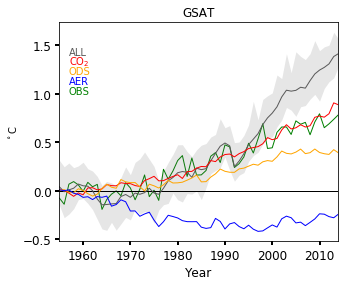

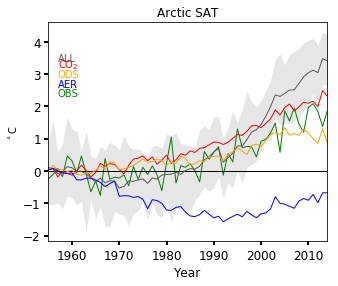

In [16]:
#==========================================================
#3. Plots  
#==========================================================
os.system('mkdir -p PLOTS')

labels={'historical':'ALL',
        'hist-noCFC':'FixODS',
        'hist-noCFC-noO3':'FixODSO3S',
        'hist-noaerosol':'Fixaerosol',
        'hist-noCO2':'FixCO2'}

colors={'historical':[0.35,0.35,0.35],
        'hist-noCFC':'orange',
        'hist-noCFC-noO3':'brown',
        'hist-noaerosol':'blue',
        'hist-noCO2':'red'        
       }

#==========================================================
#3a. Timeseries ensemble means
#==========================================================

labelsdif={'historical':'ALL',
          'hist-noCFC':'ODS', 
          'hist-noCFC-noO3':'ODSO3',
          'hist-noaerosol':'AER',
          'hist-noCO2':'CO$_2$'}

#=contributions=========================================================

############### Setup fig
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
ax.set_xlim([1955, ystop]) 
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##historical
x=data_gm['historical']-np.mean(data_gm['historical'][:,0:10])
ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors['historical'])
ax.text(1957,1.4,'ALL',color=colors['historical'])
ax.fill_between(years,np.min(x,axis=0),np.max(x,axis=0),color=colors['historical'], alpha=0.15, linewidth=0)
                
##contributions
for i,forcing in enumerate(['hist-noCO2','hist-noCFC','hist-noaerosol']):
    #plot timeseries
    x=data_gm['historical']-data_gm[forcing]    
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing])
    ax.text(1957,1.3-i*0.1,labelsdif[forcing],color=colors[forcing])
##observations
ax.plot(years,obs_gm-np.mean(obs_gm[0:10]),linewidth=1, color='green',zorder=0)

ax.text(1957,1,'OBS',color='green')
rpl.add_title(ax,'GSAT')

rpl.mysavefig(fig1,'PLOTS/tas_gm_timeseries_2014.png')

############### Setup fig
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
ax.set_xlim([1955, ystop]) 
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##historical
x=data_arc['historical']-np.mean(data_arc['historical'][:,0:10])
ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors['historical'])
ax.text(1957,3.4,'ALL',color=colors['historical'])
ax.fill_between(years,np.min(x,axis=0),np.max(x,axis=0),color=colors['historical'], alpha=0.15, linewidth=0)
                
##contributions
for i,forcing in enumerate(['hist-noCO2','hist-noCFC','hist-noaerosol']):
    #plot timeseries
    x=data_arc['historical']-data_arc[forcing]    
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing])
    ax.text(1957,3.2-i*0.3,labelsdif[forcing],color=colors[forcing])
##observations
ax.plot(years,obs_arc-np.mean(obs_arc[0:10]),linewidth=1, color='green',zorder=0)

ax.text(1957,2.3,'OBS',color='green')
rpl.add_title(ax,'Arctic SAT')

rpl.mysavefig(fig1,'PLOTS/tas_arc_timeseries_2014.png')












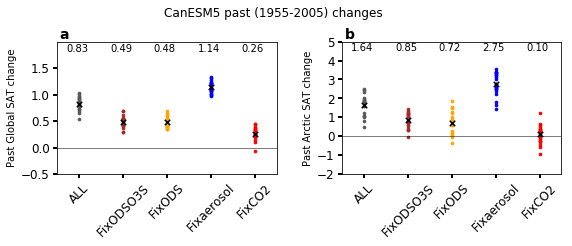

In [5]:
#==========================================================
#3b. Barplot fixedruns
#==========================================================

def plot_scatter(ax,col,nens,dtas,color):
    ax.scatter(np.ones(nens)*col,dtas,7,color)
    ax.scatter(col,np.mean(dtas),30,'black','x')

    
def barplot_fixedruns(ax,ax_label,region,ymin,ymax,forcings,data):    
    ### Title
    rpl.add_title(ax,'',ax_label)
    ### x-axis
    plot_labels=[]
    nbars=len(forcings)
    for i in range(nbars):
        plot_labels.append(labels[forcings[i]])
    ax.set_xlim([0.5, nbars+0.5]) 
    ax.set_xticks(np.arange(1,nbars+1))
    ax.set_xticklabels(plot_labels,rotation=45)
    ### y-axis
    ax.set_ylim([ymin, ymax]) 
    if region=='Global': ax.set_yticks(np.arange(np.floor(ymin*2)/2,np.ceil(ymax+1*2)/2,0.5))
    if region=='Arctic': ax.set_yticks(np.arange(np.floor(ymin),np.ceil(ymax+1),1))
    
    ax.set_ylabel('Past '+region + ' SAT change')
    ax.axhline(y=0,color="black",linewidth=0.5)

    ### model data
    for i,forcing in enumerate(forcings):
        plot_scatter(ax,i+1,nens[forcing],data[forcing],colors[forcing])
        ax.text(i+1-0.3,ymax*0.9,"%4.2f"%(np.mean(data[forcing])))

#===========ALLFIXED=============================================
fig1, axs = plt.subplots(1,2, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)

plot_forcings=['historical','hist-noCFC-noO3','hist-noCFC','hist-noaerosol','hist-noCO2']
barplot_fixedruns(axs[0],'a','Global',-0.2,2,plot_forcings,deltdecade_gm)    
barplot_fixedruns(axs[1],'b','Arctic',-2,5,plot_forcings,deltdecade_arc)    

##save
fig1.suptitle('CanESM5 past ({}-{}) changes'.format(ystart,ystop),y=0.94)
rpl.mysavefig(fig1,'PLOTS/deltdecade_past_CanESM5_fixedruns.png')




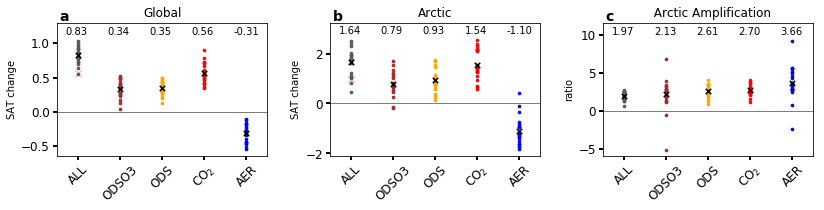

In [6]:
#==========================================================
#3c. Regular barplot  [ALL, and ALL MIN FIXED VERSION,including Arctic amplification]
#==========================================================
fig1, axs = plt.subplots(1,3, figsize=(12,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)


#Global
ax=axs[0]
ymax=1.5
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Global','a')
ax.axhline(y=0,color="black",linewidth=0.5)

x1g=deltdecade_gm['historical']; 
x2g=deltdecade_gm['historical']-deltdecade_gm['hist-noCFC-noO3']
x3g=deltdecade_gm['historical']-deltdecade_gm['hist-noCFC']
x4g=deltdecade_gm['historical']-deltdecade_gm['hist-noCO2']
x5g=deltdecade_gm['historical']-deltdecade_gm['hist-noaerosol']

plot_scatter(ax,1,20,x1g,colors['historical'])
plot_scatter(ax,2,20,x2g,colors['hist-noCFC-noO3'])
plot_scatter(ax,3,20,x3g,colors['hist-noCFC'])
plot_scatter(ax,4,20,x4g,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5g,colors['hist-noaerosol'])
ax.scatter(1,deltdecade_obs_gm,50,'pink','x',zorder=0)

ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.15])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1g)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2g)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3g)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4g)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5g)))
ax.set_xticklabels(['ALL','ODSO3','ODS','CO$_2$','AER'],rotation=45)


#Arctic
ax=axs[1]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('SAT change')
rpl.add_title(ax,'Arctic','b')
ax.axhline(y=0,color="black",linewidth=0.5)

x1a=deltdecade_arc['historical']; 
x2a=deltdecade_arc['historical']-deltdecade_arc['hist-noCFC-noO3']
x3a=deltdecade_arc['historical']-deltdecade_arc['hist-noCFC']
x4a=deltdecade_arc['historical']-deltdecade_arc['hist-noCO2']
x5a=deltdecade_arc['historical']-deltdecade_arc['hist-noaerosol']

plot_scatter(ax,1,20,x1a,colors['historical'])
plot_scatter(ax,2,20,x2a,colors['hist-noCFC-noO3'])
plot_scatter(ax,3,20,x3a,colors['hist-noCFC'])
plot_scatter(ax,4,20,x4a,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5a,colors['hist-noaerosol'])
ax.scatter(1,deltdecade_obs_arc,50,'pink','x',zorder=0)

ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.15])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1a)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2a)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3a)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4a)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5a)))
ax.set_xticklabels(['ALL','ODSO3','ODS','CO$_2$','AER'],rotation=45)

#Arctic amplification

ax=axs[2]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('ratio')
rpl.add_title(ax,'  Arctic Amplification','c')

x1aa=x1a/x1g
x2aa=x2a/x2g
x3aa=x3a/x3g
x4aa=x4a/x4g
x5aa=x5a/x5g

plot_scatter(ax,1,20,x1aa,colors['historical'])
plot_scatter(ax,2,20,x2aa,colors['hist-noCFC-noO3'])
plot_scatter(ax,3,20,x3aa,colors['hist-noCFC'])
plot_scatter(ax,4,20,x4aa,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5aa,colors['hist-noaerosol'])

ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.15])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1aa)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2aa)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3aa)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4aa)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5aa)))
ax.set_xticklabels(['ALL','ODSO3','ODS','CO$_2$','AER'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)


rpl.mysavefig(fig1,'PLOTS/deltdecade_past_CanESM5_ALL_MIN_FIXED.png')




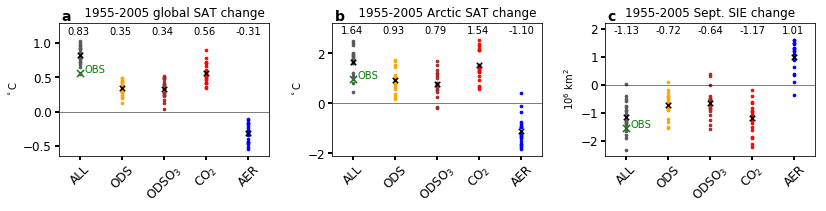

In [7]:
#==========================================================
#3d. Regular barplot  [ALL, and ALL MIN FIXED VERSION, with SSIE]
#==========================================================

# first read SSIE data (created by CFC_SIE)==========================================================
#dssie={}
with open('DATA/dssie.pickle', 'rb') as handle:
    dssie=pickle.load(handle)




#==========================================================

fig1, axs = plt.subplots(1,3, figsize=(12,8)); 
fig1.subplots_adjust(bottom=0.65,right=1,hspace=0.3,wspace=0.3)


#Global
ax=axs[0]
ymax=1.5
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('$^\circ$C')
rpl.add_title(ax,'     1955-2005 global SAT change','a')
ax.axhline(y=0,color="black",linewidth=0.5)

x1g=deltdecade_gm['historical'];
x2g=deltdecade_gm['historical']-deltdecade_gm['hist-noCFC']
x3g=deltdecade_gm['historical']-deltdecade_gm['hist-noCFC-noO3']
x4g=deltdecade_gm['historical']-deltdecade_gm['hist-noCO2']
x5g=deltdecade_gm['historical']-deltdecade_gm['hist-noaerosol']

plot_scatter(ax,1,20,x1g,colors['historical'])
plot_scatter(ax,2,20,x2g,colors['hist-noCFC'])
plot_scatter(ax,3,20,x3g,colors['hist-noCFC-noO3'])
plot_scatter(ax,4,20,x4g,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5g,colors['hist-noaerosol'])
ax.scatter(1,deltdecade_obs_gm,50,'green','x',zorder=0)
ax.text(1+0.1,deltdecade_obs_gm,'OBS',color='green')


ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.15])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1g)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2g)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3g)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4g)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5g)))
ax.set_xticklabels(['ALL','ODS','ODSO$_3$','CO$_2$','AER'],rotation=45)

#Arctic
ax=axs[1]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('$^\circ$C')
rpl.add_title(ax,'     1955-2005 Arctic SAT change','b')
ax.axhline(y=0,color="black",linewidth=0.5)

##model
x1a=deltdecade_arc['historical']; 
x2a=deltdecade_arc['historical']-deltdecade_arc['hist-noCFC']
x3a=deltdecade_arc['historical']-deltdecade_arc['hist-noCFC-noO3']
x4a=deltdecade_arc['historical']-deltdecade_arc['hist-noCO2']
x5a=deltdecade_arc['historical']-deltdecade_arc['hist-noaerosol']

plot_scatter(ax,1,20,x1a,colors['historical'])
plot_scatter(ax,2,20,x2a,colors['hist-noCFC'])
plot_scatter(ax,3,20,x3a,colors['hist-noCFC-noO3'])
plot_scatter(ax,4,20,x4a,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5a,colors['hist-noaerosol'])
##obs
ax.scatter(1,deltdecade_obs_arc,50,'green','x',zorder=0)
ax.text(1+0.1,deltdecade_obs_arc,'OBS',color='green')

ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.15])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1a)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2a)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3a)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4a)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5a)))
ax.set_xticklabels(['ALL','ODS','ODSO$_3$','CO$_2$','AER'],rotation=45)

#SSIE
ax=axs[2]
ax.set_xlim([0.5, 5.5]) 
ax.set_xticks(np.arange(1,6))
ax.set_ylabel('10$^6$ km$^2$')
rpl.add_title(ax,'1955-2005 Sept. SIE change','c')

##model
x1a=dssie['historical']; 
x2a=dssie['historical']-dssie['hist-noCFC']
x3a=dssie['historical']-dssie['hist-noCFC-noO3']
x4a=dssie['historical']-dssie['hist-noCO2']
x5a=dssie['historical']-dssie['hist-noaerosol']

plot_scatter(ax,1,20,x1a,colors['historical'])
plot_scatter(ax,2,20,x2a,colors['hist-noCFC'])
plot_scatter(ax,3,20,x3a,colors['hist-noCFC-noO3'])
plot_scatter(ax,4,20,x4a,colors['hist-noCO2'])
plot_scatter(ax,5,20,x5a,colors['hist-noaerosol'])
##obs
ax.scatter(1,-1.5248804,50,'green','x',zorder=0) #number from CFC_SIE.ipynb
ax.text(1+0.1,-1.5248804,'OBS',color='green')

ymin=ax.get_ylim()[0];ymax=ax.get_ylim()[1]
ax.set_ylim([ymin,ymax*1.2])
ax.text(1-0.3,ymax,"%4.2f"%(np.mean(x1a)))
ax.text(2-0.3,ymax,"%4.2f"%(np.mean(x2a)))
ax.text(3-0.3,ymax,"%4.2f"%(np.mean(x3a)))
ax.text(4-0.3,ymax,"%4.2f"%(np.mean(x4a)))
ax.text(5-0.3,ymax,"%4.2f"%(np.mean(x5a)))
ax.set_xticklabels(['ALL','ODS','ODSO$_3$','CO$_2$','AER'],rotation=45)
ax.axhline(y=0,color="black",linewidth=0.5)


rpl.mysavefig(fig1,'PLOTS/fig4_barplot.png')

In [8]:
#==========================================================
#4. Print out numbers 
#==========================================================

#==========================================================
#4a. % decrease in fixed versus all forcing 
#==========================================================

print 'Global warming % decrease due to ODS' 
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCFC']))/np.mean(deltdecade_gm['historical'])*100)
print 'Global warming % decrease due to CO2'
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCO2']))/np.mean(deltdecade_gm['historical'])*100)
print 'Global warming  due to ODS:'
print "%4.2f"%(np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCFC']))
print 'Global warming cue to CO2'
print "%4.2f"%(np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCO2']))
print 'Global warming ODS relative to CO2 impact'
print "%4.2f"%((np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCFC']))/(np.mean(deltdecade_gm['historical'])-np.mean(deltdecade_gm['hist-noCO2']))*100)
print ''
print 'Arctic warming % decrease due to ODS'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCFC']))/np.mean(deltdecade_arc['historical'])*100)
print 'Arctic warming % decrease due to CO2'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCO2']))/np.mean(deltdecade_arc['historical'])*100)
print 'Arctic warming ODS relative to CO2 impact'
print "%4.2f"%((np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCFC']))/(np.mean(deltdecade_arc['historical'])-np.mean(deltdecade_arc['hist-noCO2']))*100)



#==========================================================
#4b. Statistical significance of difference 
#==========================================================
print (stats.ttest_ind(deltdecade_arc['historical'],deltdecade_arc['hist-noCFC-noO3'])[1])
print (stats.ttest_ind(deltdecade_arc['hist-noCFC'],deltdecade_arc['hist-noCFC-noO3'])[1])

#==========================================================
#4c. data to outfile for Lorenzo postdoc 
#==========================================================

text_file = open("DATA/CanESM5_deltdecade.txt", "w")

for forcing in ['historical','hist-noCO2','hist-noCFC-noO3']:
    text_file.write(labels[forcing]+ '\n')
    text_file.write("global  arctic " + '\n')

    for i in range(20):
        text_file.write("%6.4f"%(deltdecade_gm[forcing][i]) + '   '
                       +"%6.4f"%(deltdecade_arc[forcing][i]) + '  '+ '\n')
                                 
text_file.close()            


text_file = open("DATA/CanESM5_delttrend.txt", "w")

for forcing in ['historical','hist-noCO2','hist-noCFC-noO3']:
    
    text_file.write(labels[forcing]+ '\n')
    text_file.write("global  arctic " + '\n')

    for i in range(20):
        text_file.write("%6.4f"%(delttrend_gm[forcing][i]) + '   '
                       +"%6.4f"%(delttrend_arc[forcing][i]) + '  '+ '\n')
                                 
text_file.close()            







Global warming % decrease due to ODS
41.86
Global warming % decrease due to CO2
68.03
Global warming  due to ODS:
0.35
Global warming cue to CO2
0.56
Global warming ODS relative to CO2 impact
61.53

Arctic warming % decrease due to ODS
56.46
Arctic warming % decrease due to CO2
93.97
Arctic warming ODS relative to CO2 impact
60.08
5.091173664284578e-06
0.3978305451199544


In [9]:
#==========================================================
#6. bootstrapping all minus fixODSO3 
#==========================================================

s1=delttrend_arc['historical']
s2=delttrend_arc['hist-noCFC-noO3']

nens=65;nboot=10000
s1_boot_mean=np.zeros((nens))
s1_boot_min=np.zeros((nens))
s1_boot_max=np.zeros((nens))

for nsamp in range (nens):
    s1_boot=np.zeros((nboot))
    
    for iboot in range(nboot):
        resample_i = np.floor(np.random.rand(nsamp+1)*nens).astype(int)
        s1_boot[iboot]=np.mean(s1[resample_i]) 
        
    s1_boot_mean[nsamp],s1_boot_min[nsamp],s1_boot_max[nsamp],a=rutb.calc_boot_stats(s1_boot,sides=1)

    
nens=20
s2_boot_mean=np.zeros((nens))
s2_boot_min=np.zeros((nens))
s2_boot_max=np.zeros((nens))

for nsamp in range (nens):
    s2_boot=np.zeros((nboot))
    
    for iboot in range(nboot):
        resample_i = np.floor(np.random.rand(nsamp+1)*nens).astype(int)
        s2_boot[iboot]=np.mean(s2[resample_i]) 
        
    s2_boot_mean[nsamp],s2_boot_min[nsamp],s2_boot_max[nsamp],a=rutb.calc_boot_stats(s2_boot,sides=1)
    
################PLOT

ncol=1; nrow=1;fig7, axs = plt.subplots(nrow,ncol, figsize=(ncol*2.5,nrow*2.5));     


####Ensembles
ax=axs
ax.set_xlim([1, 20])
ax.set_xticks(np.arange(5,20,5))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1)) 
ax.set_xlabel('Ensemble size',fontsize=11)

#ax.plot(np.arange(1,66),s1_boot_mean,color=[0.35,0.35,0.35],linewidth=0.5)
#ax.plot(np.arange(1,66),s1_boot_min,color=[0.35,0.35,0.35],linewidth=0.5)
#ax.plot(np.arange(1,66),s1_boot_max,color=[0.35,0.35,0.35],linewidth=0.5)
ax.fill_between(np.arange(1,66),s1_boot_min,s1_boot_max,color=colors['historical'])
ax.fill_between(np.arange(1,21),s2_boot_min,s2_boot_max,color=colors['hist-noCFC-noO3'],alpha=0.5)

ax.text(13,2.9,'ALL',color=colors['historical'])
ax.text(13,2.6,'FixODSO3',color=colors['hist-noCFC-noO3'])
ax.set_ylabel('($^\circ$C)',fontsize=11)

rpl.mysavefig(fig7,'PLOTS/deltdecade_tas_function_of_ensemble_size.png')    

print s1_boot_min[49]
print s1_boot_max[49]
print s1_boot_mean[49]

IndexError: index 51 is out of bounds for axis 1 with size 20